# Data Exploration

__We will attempt to build a binary classifier for the education deserts using census tract data to reveal which features are most useful in determining whether a census tract is an education desert or not__

---
## Binary Classifier
__In this section we will first perform PCA on the large dataset of census tract features, and afterwards use vanilla classification models to predict whether a census tract is an education or not__

In [1]:
# Library Imports
import json
import fiona 
import rtree
import shapely
import pandas as pd
import numpy as np
from time import time
import subprocess
import os
import requests
from bs4 import BeautifulSoup
import seaborn as sns
sns.set(style="ticks")

# default dictionary (a dictionary with a default value if a key doesn't exist)
from collections import defaultdict

# To unzip file
import zipfile

# To have progress bar
from tqdm import tqdm

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
%matplotlib inline

# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

---
## Datasets

In [2]:
# Census tracts data url from 2012 - 2017
ct_file_name = 'acs_5_year_estimates_census_tracts.csv'

# American University Data
au_file_name = 'IPEDS_data.xlsx'

# Directory of datasets
DATASETS_PATH = 'datasets/'

# JSON file for dictionary of census tracts 
# and the census tracts within BUFFER
tracts_in_buffer_file_name = 'tracts_in_buffer.json'

# CSV file containing the labels of
# each census tract being an education desert or not
education_deserts_file_name = 'education_deserts.csv'

### Census Tract Data

__Census Tracts have a population of around ${2,500}$ - ${8,000}$ people__

In [3]:
# Let's take a look at the census tract data
census_tracts = pd.read_csv(DATASETS_PATH + ct_file_name, encoding='ISO-8859-1', low_memory=False, index_col='FIPS')
census_tracts.head()

,Geographic Identifier,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),Summary Level,Geographic Component,File Identification,Logical Record Number,US,Region,...,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months Below Poverty Level: Male: in Labor Force: Employed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months Below Poverty Level: Male: in Labor Force: Unemployed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months Below Poverty Level: Male: Not in Labor Force,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: in Labor Force,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: in Labor Force: Employed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: in Labor Force: Unemployed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: Not in Labor Force,Households.1,Households with Housing Costs more than 30% of Income
FIPS,,,,,,,,,,,,,,,,,,,,,
Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,...,SE_T254_004,SE_T254_005,SE_T254_006,SE_T254_007,SE_T254_008,SE_T254_009,SE_T254_010,SE_T254_011,SE_T255_001,SE_T255_002
01001020100,14000US01001020100,"Census Tract 201, Autauga County, Alabama","Census Tract 201, Autauga County, Alabama",al,140,00,ACSSF,0001766,NaN,NaN,...,36,7,80,1360,880,845,35,480,754,144
01001020200,14000US01001020200,"Census Tract 202, Autauga County, Alabama","Census Tract 202, Autauga County, Alabama",al,140,00,ACSSF,0001767,NaN,NaN,...,59,0,204,1230,823,793,30,407,783,218
01001020300,14000US01001020300,"Census Tract 203, Autauga County, Alabama","Census Tract 203, Autauga County, Alabama",al,140,00,ACSSF,0001768,NaN,NaN,...,61,3,305,2291,1491,1421,70,800,1279,357
01001020400,14000US01001020400,"Census Tract 204, Autauga County, Alabama","Census Tract 204, Autauga County, Alabama",al,140,00,ACSSF,0001769,NaN,NaN,...,16,0,66,3241,1953,1833,120,1288,1749,361


__Let's look at what features are in this dataframe__

In [4]:
# Since we have 2161 features, let's first remove
# those that we will definitely not use, so
# let's try to see what we can remove in the first
# few columns since they seem like the ones that have
# no feature importance... Also let's see which 
# columns have categorical data
# for idx, feat in enumerate(census_tracts.columns):
#     print('{}. {} : e.g. {}'.format(idx, feat, census_tracts[feat][1]))
#     if idx >= 50:
#         break;

In [5]:
census_tracts['Public Use Microdata Area - 1% File'].head()

FIPS
Geo_FIPS       Geo_PUMA1
01001020100          NaN
01001020200          NaN
01001020300          NaN
01001020400          NaN
Name: Public Use Microdata Area - 1% File, dtype: object

__Seems like everything until `Total Population` might not be useful, so let's remove it along with the first row (just internal id labels for each feature) and `Total Population.1` since it's a duplicate__

In [6]:
# census_tracts = census_tracts.loc[:, 'Total Population':].drop(['Total Population.1', 'Total Population:', 'Total Population:.1'], axis=1)
# census_tracts.head()

In [7]:
# Features to keep by Lucas
to_keep = [
    
    # Locational:
    46,
    
    #Demographics:
    61, 56, 62, 278, 279, 280, 281, 282, 283, 284, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
    
    # Education:
    614, 606, 548, 549, 550, 551, 552, 553, 554, 547,
    
    # Employment:
    634, 628, 630, 633, 629,

    # Income:
    763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 762, 880, 1233, 1383, 1382, 1410, 1411, 1412, 1409

]

# Dictionary to keep track of the mapping of original
# indices to column names
feature_cols = {col_idx: census_tracts.columns[col_idx] for col_idx in to_keep}

# Only keep the features by indices listed in to_keep
census_tracts = census_tracts.iloc[:, to_keep]
census_tracts.head()

,Urban/Rural,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,...,"Households: $200,000 or More",Households:.3,Median Household Income (In 2017 Inflation Adjusted Dollars),Median Gross Rent,Families: Income in Below Poverty Level,Families:,Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Population for Whom Poverty Status Is Determined:.1
FIPS,,,,,,,,,,,,,,,,,,,,,
Geo_FIPS,Geo_UR,SE_T004_001,SE_T002_002,SE_T004_002,SE_T013_002,SE_T013_003,SE_T013_004,SE_T013_005,SE_T013_006,SE_T013_007,...,SE_T056_017,SE_T056_001,SE_T057_001,SE_T104_001,SE_T113_002,SE_T113_001,SE_T118_002,SE_T118_003,SE_T118_004,SE_T118_001
01001020100,NaN,1845,487.1106,899,1636,96,0,22,0,0,...,16,754,67826,780,67,557,197,216,413,1845
01001020200,NaN,2172,1684.013,1167,913,1184,0,22,14,7,...,0,783,41287,735,92,503,442,435,877,1972
01001020300,NaN,3385,1638.934,1533,2078,896,19,25,12,272,...,0,1279,46806,882,83,827,496,950,1446,3385
01001020400,NaN,4267,1731.473,2001,3443,356,20,10,0,320,...,9,1749,55895,924,17,1163,98,779,877,4267


In [8]:
census_tracts = census_tracts.drop('Geo_FIPS', axis=0)
census_tracts.head()

,Urban/Rural,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,...,"Households: $200,000 or More",Households:.3,Median Household Income (In 2017 Inflation Adjusted Dollars),Median Gross Rent,Families: Income in Below Poverty Level,Families:,Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Population for Whom Poverty Status Is Determined:.1
FIPS,,,,,,,,,,,,,,,,,,,,,
01001020100,NaN,1845,487.1106,899,1636,96,0,22,0,0,...,16,754,67826,780,67,557,197,216,413,1845
01001020200,NaN,2172,1684.013,1167,913,1184,0,22,14,7,...,0,783,41287,735,92,503,442,435,877,1972
01001020300,NaN,3385,1638.934,1533,2078,896,19,25,12,272,...,0,1279,46806,882,83,827,496,950,1446,3385
01001020400,NaN,4267,1731.473,2001,3443,356,20,10,0,320,...,9,1749,55895,924,17,1163,98,779,877,4267
01001020500,NaN,9965,2264.419,5054,7817,1638,0,305,0,0,...,84,4194,68143,1194,237,2817,1194,1299,2493,9759


### Feature Engineering

__Let's create some new features using our current features__

'''

    Lucas:

    *Current thoughts on what features to study*:
    Locational:
    • Urban or rural (feat 46)

    Demographics:
    • Total population (feat 61)
    • Population density (feat 56)
    • Pct. of population that is male (feat 62, divided by total pop)
    • Pct. of each race (feats 278-284, divided by total pop)
    • Pct population in each age group (feats 153-164, divided by total pop)

    Education:
    • Pct. students enrolled in private school (feat 614, divided by feat 606)
    • Pct. population age 25+ at each education level (feats 548-554, divided by feat 547)

    Employment:
    • Pct. pop 16+ not in labor force (feat 634, divided by feat 628)
    • Pct. pop 16+ in armed forces (feat 630, divided by feat 628)
    • Pct. pop 16+ unemployed (feat 633, divided by feat 629)

    Income:
    • Pct. of households in each income bracket (feats 763-778, divided by feat 762)
    • Median household income (feat 880)
    • Median gross rent (feat 1233)
    • Pct. families below poverty level (feat 1383, divided by feat 1382). Or Pct. population at each poverty level (feats 1410-1412, divided by feat 1409) (edited) 

    I think this would give us a pretty reasonable number of features ^, so that we can actually investigate the importance of each one independently. They also seem like pretty common-sense features that would be important for our task
    There was some data on the breakdown of different job sectors too, but imo it was too many sectors to include --> could lead to overfitting
    
'''

In [9]:
# List of columns we are working with
feature_cols

{46: 'Urban/Rural',
 56: 'Population Density (Per Sq. Mile)',
 61: 'Total Population:',
 62: 'Total Population: Male',
 153: 'Total Population: Under 5 Years',
 154: 'Total Population: 5 to 9 Years',
 155: 'Total Population: 10 to 14 Years',
 156: 'Total Population: 15 to 17 Years',
 157: 'Total Population: 18 to 24 Years',
 158: 'Total Population: 25 to 34 Years',
 159: 'Total Population: 35 to 44 Years',
 160: 'Total Population: 45 to 54 Years',
 161: 'Total Population: 55 to 64 Years',
 162: 'Total Population: 65 to 74 Years',
 163: 'Total Population: 75 to 84 Years',
 164: 'Total Population: 85 Years and Over',
 278: 'Total Population: White Alone',
 279: 'Total Population: Black or African American Alone',
 280: 'Total Population: American Indian and Alaska Native Alone',
 281: 'Total Population: Asian Alone',
 282: 'Total Population: Native Hawaiian and Other Pacific Islander Alone',
 283: 'Total Population: Some Other Race Alone',
 284: 'Total Population: Two or More Races',
 54

In [10]:
# ----------------- Feature Engineer: Demographics ----------------- 

# Percentage Males
census_tracts['Pct. Male'] = pd.to_numeric(census_tracts[feature_cols[62]]) / pd.to_numeric(census_tracts[feature_cols[61]])

# Percentage of each Race
for race in range(278, 284 + 1):
    census_tracts['Pct. {}'.format(feature_cols[race].split(':')[1].strip())] = pd.to_numeric(census_tracts[feature_cols[race]]) / pd.to_numeric(census_tracts[feature_cols[61]])

# Percentage of each age group
for age_group in range(153, 164 + 1):
    census_tracts['Pct. {}'.format(feature_cols[age_group].split(':')[1].strip())] = pd.to_numeric(census_tracts[feature_cols[age_group]]) / pd.to_numeric(census_tracts[feature_cols[61]])
    
# ----------------- Feature Engineer: Education -----------------    
    
# Percentage of students enrolled in private school  
census_tracts['Pct. Students enrolled in private school'] = pd.to_numeric(census_tracts[feature_cols[614]]) / pd.to_numeric(census_tracts[feature_cols[606]])
    
# Percentage of population age 25+ at each education level
for edu_lvl in range(548, 554 + 1):
    census_tracts['Pct. {}'.format(feature_cols[edu_lvl])] = pd.to_numeric(census_tracts[feature_cols[edu_lvl]]) / pd.to_numeric(census_tracts[feature_cols[547]])
    
# ----------------- Feature Engineer: Employment -----------------  

# Percentage of pop 16+ not in labor force (feat 634, divided by feat 628)
census_tracts['Pct. Pop 16+ not in labor force'] = pd.to_numeric(census_tracts[feature_cols[634]]) / pd.to_numeric(census_tracts[feature_cols[628]])

# Percentage of pop 16+ in armed force (feat 630, divided by feat 628)
census_tracts['Pct. Pop 16+ in armed forces'] = pd.to_numeric(census_tracts[feature_cols[630]]) / pd.to_numeric(census_tracts[feature_cols[628]])

# Percentage of pop 16+ unemployed (feat 633, divided by feat 629)
census_tracts['Pct. Pop 16+ unemployed'] = pd.to_numeric(census_tracts[feature_cols[633]]) / pd.to_numeric(census_tracts[feature_cols[629]])

# ----------------- Feature Engineer: Income -----------------  

# Percentage of households in each income bracket (feats 763-778, divided by feat 762)
for income_lvl in range(763, 778 + 1):
    census_tracts['Pct. {}'.format(feature_cols[income_lvl])] = pd.to_numeric(census_tracts[feature_cols[income_lvl]]) / pd.to_numeric(census_tracts[feature_cols[762]])

# Percentage of families below poverty level (feat 1383, divided by feat 1382).
census_tracts['Pct. Families below poverty level'] = pd.to_numeric(census_tracts[feature_cols[1383]]) / pd.to_numeric(census_tracts[feature_cols[1382]])

# Percentage of population at each poverty level (feats 1410-1412, divided by feat 1409)
for poverty_lvl in range(1410, 1412 + 1):
    census_tracts['Pct. {}'.format(feature_cols[poverty_lvl])] = pd.to_numeric(census_tracts[feature_cols[poverty_lvl]]) / pd.to_numeric(census_tracts[feature_cols[1409]])

    

__Let's proceed to check if any columns contain missing data__

In [11]:
contain_nans = 0
for idx, feat in enumerate(census_tracts.columns):
    if census_tracts[feat].isnull().values.any():
        contain_nans += 1
#         print(feat + ' contains missing values...')
    
print(contain_nans)

55


__Let's see which of these columns have > 25% missing data and remove them because it'll be an unreliable feature for us to use__

In [12]:
bad_col_inds = (census_tracts.isna().sum() / census_tracts.shape[0]) > 0.25
census_tracts = census_tracts[census_tracts.columns[~bad_col_inds]]

__We will impute the most frequest value for the columns with NaNs__

In [13]:
# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent')
imputer = imputer.fit(census_tracts.loc[:, census_tracts.isna().any()])
census_tracts.loc[:, census_tracts.isna().any()] = imputer.transform(census_tracts.loc[:, census_tracts.isna().any()])

/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Dictionary of Census Tract GeoID to List of Census Tracts within Buffer Radius

__Let's read in the JSON file to load the dictionary of which census tracts are within buffer radius__

In [14]:
# Reading JSON
with open(DATASETS_PATH + tracts_in_buffer_file_name, 'r') as f:
    tracts_in_buffer = json.load(f)
    
for i in tracts_in_buffer.items():
    print(i)
    break;

('34025810102', ['36085029103', '36085009602', '36085011401', '36085018100', '36085027301', '36085029104', '36085007000', '36085018702', '36085018901', '36085018902', '36085006400', '36085009601', '36085017300', '36085018701', '36085025100', '36085002002', '36085030301', '36085016901', '36085017700', '36085005000', '36085015100', '36085030302', '36085020100', '36085023100', '36085031901', '36085023900', '36085032300', '36085031902', '36085019700', '36085027302', '34025990000', '36085007400', '34035050100', '34035050200', '34035050300', '34035050903', '34035050902', '34035052203', '34035051200', '34035051300', '34035051100', '34035053000', '34023000100', '34023000701', '34023000200', '34035052100', '34023000403', '34023000300', '34035052002', '34023000401', '34035051900', '34023000404', '34039039400', '34035051800', '34023000603', '34023000501', '34039039500', '34035051700', '34035052300', '34035052001', '34039039300', '34023000502', '34023000801', '34039039600', '34039038900', '3403903

### DataFrame of Education desert labels for each census tract

__Let's read in the CSV File to load the pandas dataframe of education desert labels__

In [15]:
# Reading CSV
edu_deserts = pd.read_csv(DATASETS_PATH + education_deserts_file_name, index_col=0)
edu_deserts.head()

,Number of Accessible Universities,Education Desert
34025810102,8,0
17097865501,10,0
49005000501,2,0
26093722100,2,0
37137950201,0,1


__Let's convert the census_tracts index to Int64 to be compatible in comparison with the education deserts dataframe__

In [16]:
census_tracts.index = census_tracts.index.astype('int64')
census_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74001 entries, 1001020100 to 72153750602
Columns: 113 entries, Total Population: to Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling)
dtypes: float64(54), object(59)
memory usage: 64.4+ MB


__Let's do an inner join of the Education desert labels and the census tract data so that we only keep the census tract data for those that have the label of whether its an education desert or not__

In [17]:
merged_census_df = census_tracts.merge(right=edu_deserts, how="inner", left_on=census_tracts.index, right_on=edu_deserts.index)
merged_census_df.head()

,key_0,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,...,"Pct. Households: $100,000 to $124,999","Pct. Households: $125,000 to $149,999","Pct. Households: $150,000 to $199,999","Pct. Households: $200,000 or More",Pct. Families below poverty level,Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Number of Accessible Universities,Education Desert
0,1001020100,1845,487.1106,899,1636,96,0,22,0,0,...,0.074271,0.079576,0.090186,0.021220,0.120287,0.106775,0.117073,0.223848,5,0
1,1001020200,2172,1684.0130,1167,913,1184,0,22,14,7,...,0.089400,0.040868,0.015326,0.000000,0.182903,0.224138,0.220588,0.444726,5,0
2,1001020300,3385,1638.9340,1533,2078,896,19,25,12,272,...,0.078968,0.039093,0.027365,0.000000,0.100363,0.146529,0.280650,0.427179,5,0
3,1001020400,4267,1731.4730,2001,3443,356,20,10,0,320,...,0.104631,0.032590,0.038308,0.005146,0.014617,0.022967,0.182564,0.205531,5,0
4,1001020500,9965,2264.4190,5054,7817,1638,0,305,0,0,...,0.178827,0.048164,0.054125,0.020029,0.084132,0.122349,0.133108,0.255457,5,0


In [18]:
merged_census_df.index = merged_census_df.iloc[:, 0]
merged_census_df.index.name = 'geoID'
merged_census_df.drop(['key_0'], axis=1, inplace=True)
merged_census_df.head()

,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,...,"Pct. Households: $100,000 to $124,999","Pct. Households: $125,000 to $149,999","Pct. Households: $150,000 to $199,999","Pct. Households: $200,000 or More",Pct. Families below poverty level,Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Number of Accessible Universities,Education Desert
geoID,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,487.1106,899,1636,96,0,22,0,0,91,...,0.074271,0.079576,0.090186,0.021220,0.120287,0.106775,0.117073,0.223848,5,0
1001020200,2172,1684.0130,1167,913,1184,0,22,14,7,32,...,0.089400,0.040868,0.015326,0.000000,0.182903,0.224138,0.220588,0.444726,5,0
1001020300,3385,1638.9340,1533,2078,896,19,25,12,272,83,...,0.078968,0.039093,0.027365,0.000000,0.100363,0.146529,0.280650,0.427179,5,0
1001020400,4267,1731.4730,2001,3443,356,20,10,0,320,118,...,0.104631,0.032590,0.038308,0.005146,0.014617,0.022967,0.182564,0.205531,5,0
1001020500,9965,2264.4190,5054,7817,1638,0,305,0,0,205,...,0.178827,0.048164,0.054125,0.020029,0.084132,0.122349,0.133108,0.255457,5,0


In [19]:
# Write to csv file for Part 2 of Project
merged_census_df.to_csv(r'./datasets/census_tract_feats.csv')

In [20]:
# Drop Number of Accessible Universities because this feature will obviously
# make prediction very easy
merged_census_df.drop(['Number of Accessible Universities'], axis=1, inplace=True)
merged_census_df.head()

,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,...,"Pct. Households: $75,000 to $99,999","Pct. Households: $100,000 to $124,999","Pct. Households: $125,000 to $149,999","Pct. Households: $150,000 to $199,999","Pct. Households: $200,000 or More",Pct. Families below poverty level,Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Education Desert
geoID,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,487.1106,899,1636,96,0,22,0,0,91,...,0.180371,0.074271,0.079576,0.090186,0.021220,0.120287,0.106775,0.117073,0.223848,0
1001020200,2172,1684.0130,1167,913,1184,0,22,14,7,32,...,0.139208,0.089400,0.040868,0.015326,0.000000,0.182903,0.224138,0.220588,0.444726,0
1001020300,3385,1638.9340,1533,2078,896,19,25,12,272,83,...,0.046130,0.078968,0.039093,0.027365,0.000000,0.100363,0.146529,0.280650,0.427179,0
1001020400,4267,1731.4730,2001,3443,356,20,10,0,320,118,...,0.161807,0.104631,0.032590,0.038308,0.005146,0.014617,0.022967,0.182564,0.205531,0
1001020500,9965,2264.4190,5054,7817,1638,0,305,0,0,205,...,0.153314,0.178827,0.048164,0.054125,0.020029,0.084132,0.122349,0.133108,0.255457,0


__Ok cool, we've now removed the missing values, and matched the observations (census tracts) to their respective labels, so now let's log transform and standardize the data first because values like `Total Population` are in the thousands, while `Area` is below 100s__

__*For classification, we want some raw features as well*__

---
## Log Transform and Standardization of Features

In [21]:
# Allocating our X (independent vars) and y (dependent vars) data
X = merged_census_df.iloc[:, :-1]
y = merged_census_df.iloc[:, -1]

In [22]:
# Log Transform and append those features
# log_X = X.apply(lambda x: np.log(x + 1))
# X = pd.concat(X, , )

In [23]:
# Import standard scaler module
from sklearn.preprocessing import StandardScaler

X_standard_scaler = StandardScaler()
X = pd.DataFrame(X_standard_scaler.fit_transform(X), index=X.index, columns=X.columns)

X.head()

/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,...,"Pct. Households: $60,000 to $74,999","Pct. Households: $75,000 to $99,999","Pct. Households: $100,000 to $124,999","Pct. Households: $125,000 to $149,999","Pct. Households: $150,000 to $199,999","Pct. Households: $200,000 or More",Pct. Families below poverty level,Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling)
geoID,,,,,,,,,,,,,,,,,,,,,
1001020100,-1.152046,-0.409075,-1.135353,-0.802360,-0.496516,-0.193605,-0.415579,-0.140031,-0.480896,-0.286018,...,-0.059971,1.193083,-0.149237,0.774162,0.719829,-0.441942,-0.020819,-0.417630,-0.723131,-0.632386
1001020200,-1.004599,-0.309729,-0.895048,-1.170794,0.679671,-0.193605,-0.415579,0.113492,-0.465444,-0.633603,...,-1.350717,0.408289,0.171465,-0.251506,-0.768684,-0.693558,0.516471,0.504949,0.357333,0.508719
1001020300,-0.457645,-0.313470,-0.566870,-0.577121,0.368327,-0.090966,-0.409674,0.077275,0.119525,-0.333148,...,1.143636,-1.366291,-0.049664,-0.298551,-0.529292,-0.693558,-0.191787,-0.105129,0.984242,0.418065
1001020400,-0.059943,-0.305789,-0.147233,0.118471,-0.215442,-0.085564,-0.439196,-0.140031,0.225482,-0.126953,...,0.068895,0.839140,0.494334,-0.470868,-0.311713,-0.632542,-0.927551,-1.076437,-0.039556,-0.727018
1001020500,2.509341,-0.261554,2.590273,2.347422,1.170469,-0.193605,0.141396,-0.140031,-0.480896,0.385589,...,0.003978,0.677227,2.067099,-0.058186,0.002799,-0.456071,-0.331059,-0.295208,-0.555764,-0.469091


---
## Imbalanced Data

__Before we jump into any analysis, let's first check the split of our data - how many observations do we have that are education deserts and how many are not__

In [24]:
print('Number of Education Deserts in our dataset: {}'.format(len(y[y == 1])))
print('Number of Non-Education Deserts in our dataset: {}'.format(len(y[y == 0])))

Number of Education Deserts in our dataset: 10230
Number of Non-Education Deserts in our dataset: 63515


__Seems like our data is very imbalanced, so we really need to do something about that__

__Sweet, we've finally got a nice dataset to work with now, let's just jump in and perform PCA first to reduce the number of features we're working with__

---
## Principal Component Analysis

In [25]:
# # Import sklearn decomposition module
# from sklearn import decomposition
# pca = decomposition.PCA(n_components='mle')

# X = pca.fit_transform(X)

# print("New feature set shape:", X.shape)

---
## Vanilla Classifiers

__Let's just try out a few classifiers straight out of sklearn on the dataset__

__Train Test Split__

In [26]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.33, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 49409 samples.
Testing set has 24336 samples.


__We will first try out the following models:__
1. Multi-Layer Perceptron
2. K-Nearest Neighbours
3. Support Vector Classifier
4. GaussianProcess Classifier
5. Decision Tree Classifier
6. Random Forest Classifier
7. AdaBoost Classifier
8. Gaussian Naive Bayes Classifier

In [27]:
# Import models from sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [28]:
# Declare Dictionary of classifiers
classifiers = { 
    'mlp': MLPClassifier(),
#     'knn': KNeighborsClassifier(),
    'svc': SVC(),
#     'gp': GaussianProcessClassifier(), # Need to subsample - randomly select 1000
    'rf': RandomForestClassifier(),
    'ada': AdaBoostClassifier(),
#     'nb': GaussianNB() 
}

In [29]:
# Model utilility functions to visualize and assist in training
from sklearn.metrics import accuracy_score, fbeta_score, recall_score, precision_score, roc_auc_score
import matplotlib.patches as mpatches

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
        Helper function to train and predict on the test set 
        and returns a results dictionary of key metric name and 
        value metric value
    '''
    results = {}
    # Get start time
    start = time() 
    # Fit the model
    learner = learner.fit(X_train, y_train) 
    # Get end time
    end = time() 
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get start time
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    # Get end time
    end = time()
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # ----------------- ACCURACY -----------------
    # Compute accuracy on all training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # ----------------- RECALL -----------------
    # Compute recall on all training samples
    results['rec_train'] = recall_score(y_train, predictions_train)
        
    # Compute recall on test set using accuracy_score()
    results['rec_test'] = recall_score(y_test, predictions_test)
    
    # ----------------- PRECISION -----------------
    # Compute precision on all training samples
    results['prec_train'] = precision_score(y_train, predictions_train)
        
    # Compute precision on test set using accuracy_score()
    results['prec_test'] = precision_score(y_test, predictions_test)
    
    # ----------------- F1 -----------------
    # Compute F1-score on all training samples
    results['f1_train'] = fbeta_score(y_train, predictions_train, beta=1)
        
    # Compute F1-score on the test set
    results['f1_test'] = fbeta_score(y_test, predictions_test, beta=1)
    
    # ----------------- ROC AUC -----------------
    # Compute AUC on all training samples
    results['auc_train'] = roc_auc_score(y_train, predictions_train)
        
    # Compute AUC on test set using accuracy_score()
    results['auc_test'] = roc_auc_score(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(X_train)))
        
    # Return the results
    return results

def evaluate(results):
    ''' 
        Helper function for vizualization of classifiers
        given the results dictionary
    '''
    # Create figure
    fig, ax = plt.subplots(2, 6, figsize = (16, 8))

    # Constants
    bar_width = 0.35
    n_mods = len(results.keys())
    r = lambda: np.random.randint(0,255)
    color_list = ['#%02X%02X%02X' % (r(),r(),r()) for learner in results.keys()]
    
    for i, metric in enumerate(['train_time', 'acc_train', 'rec_train', 'prec_train', 'f1_train', 'auc_train',
                                'pred_time', 'acc_test', 'rec_test', 'prec_test', 'f1_test', 'auc_test']):
        learner_metrics = [metrics[metric] for learner, metrics in results.items()]
        if i < 6:
            ax[0, i].bar(np.arange(n_mods), learner_metrics, bar_width, color=color_list, label=metric)
#             ax[0, i].set_xticks([learner for learner in results.keys()])
        else:
            ax[1, i - 6].bar(np.arange(n_mods), learner_metrics , bar_width, color=color_list, label=metric)
#             ax[1, i - 6].set_xticks([learner for learner in results.keys()])
    
    # Add unique y-labels
    for row in range(2):
        ax[row, 0].set_ylabel("Time (in seconds)")
        ax[row, 1].set_ylabel("Accuracy Score")
        ax[row, 2].set_ylabel("Recall score")
        ax[row, 3].set_ylabel("Precision score")
        ax[row, 4].set_ylabel("F1 score")
        ax[row, 5].set_ylabel("AUC score")
    
    # Add titles Training set
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Set")
    ax[0, 2].set_title("Recall Score on Training Set")
    ax[0, 3].set_title("Precision Score on Training Set")
    ax[0, 4].set_title("F1 score on Training Set")
    ax[0, 5].set_title("AUC score on Training Set")
    
    # Add titles Test set
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("Recall Score on Testing Set")
    ax[1, 3].set_title("Precision Score on Testing Set")
    ax[1, 4].set_title("F1 score on Testing Set")
    ax[1, 5].set_title("AUC score on Testing Set")
    
    # Set y-limits for score panels
    for row in range(2):
        ax[row, 1].set_ylim((0, 1))
        ax[row, 2].set_ylim((0, 1))
        ax[row, 3].set_ylim((0, 1))
        ax[row, 4].set_ylim((0, 1))
        ax[row, 5].set_ylim((0, 1))

#     # Create patches for the legend
#     patches = []
#     for i, learner in enumerate(results.keys()):
#         if i >= 3:
#             break
#         patches.append(mpatches.Patch(color = colors[i], label = learner))
#     plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
#                loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
#     # Aesthetics
#     plt.suptitle("Performance Metrics for Classifiers", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

def k_feature_plot(importances, X_train, y_train, k=5):
    ''' 
        Helper function to plot the k most important features
        given a feature_importance_ from an sklearn model
    '''
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:k]]
    values = importances[indices][:k]

    # Creat the plot
    fig = plt.figure(figsize = (12, 8))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 15)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns, rotation=45, fontsize = 15)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 15)
    plt.xlabel("Feature", fontsize = 15)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [30]:
# Collect results on the learners
# TODO: Add K-fold Cross Validation
classifier_results = {}
for key, classifier in classifiers.items():
    classifier_name = classifier.__class__.__name__
    classifier_results[classifier_name] = train_predict(classifier, X_train, y_train, X_test, y_test)

/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MLPClassifier trained on 49409 samples.
SVC trained on 49409 samples.


/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 49409 samples.
AdaBoostClassifier trained on 49409 samples.


In [31]:
classifier_results

{'AdaBoostClassifier': {'acc_test': 0.8884368836291914,
  'acc_train': 0.8900807545184076,
  'auc_test': 0.698332019552964,
  'auc_train': 0.6999992466915577,
  'f1_test': 0.5210795554771565,
  'f1_train': 0.523805348531346,
  'prec_test': 0.6506607929515419,
  'prec_train': 0.6530389156099694,
  'pred_time': 0.30798912048339844,
  'rec_test': 0.43453957046190056,
  'rec_train': 0.43727126335821986,
  'train_time': 19.293691158294678},
 'MLPClassifier': {'acc_test': 0.8785749506903353,
  'acc_train': 0.9466696350867251,
  'auc_test': 0.7320312342904391,
  'auc_train': 0.8779840787383976,
  'f1_test': 0.548786074209803,
  'f1_train': 0.8023700592514812,
  'prec_test': 0.5704761904761905,
  'prec_train': 0.8226699477083974,
  'pred_time': 0.05732107162475586,
  'rec_test': 0.5286849073256841,
  'rec_train': 0.7830478700043917,
  'train_time': 37.04414105415344},
 'RandomForestClassifier': {'acc_test': 0.8866288625904011,
  'acc_train': 0.9892934485620029,
  'auc_test': 0.6473767749682874

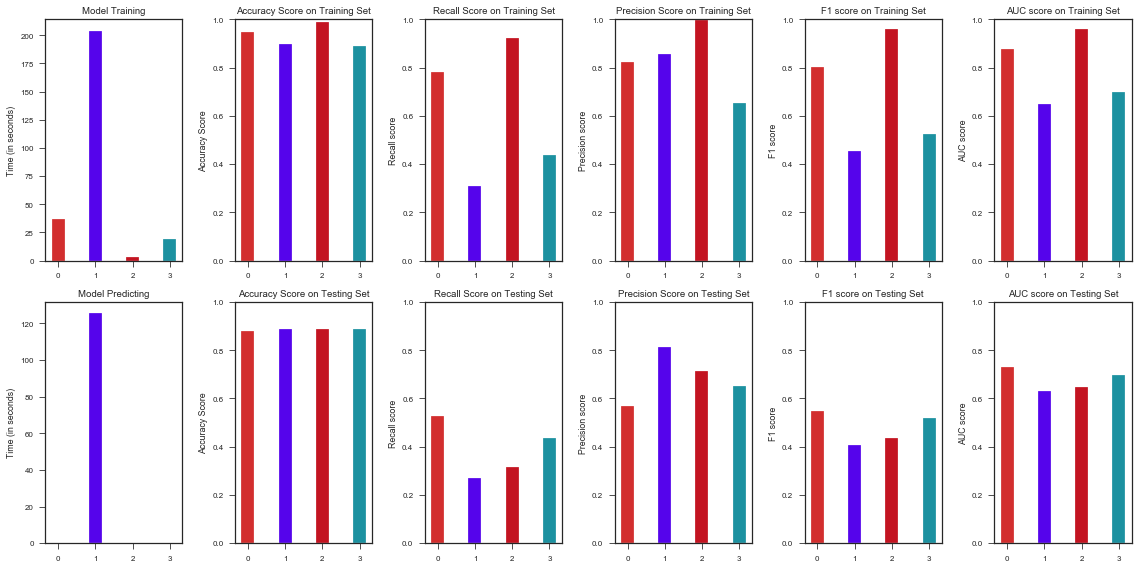

In [32]:
# TODO: Run metrics visualization for the three supervised learning models chosen
evaluate(classifier_results)

---
## Feature Importance

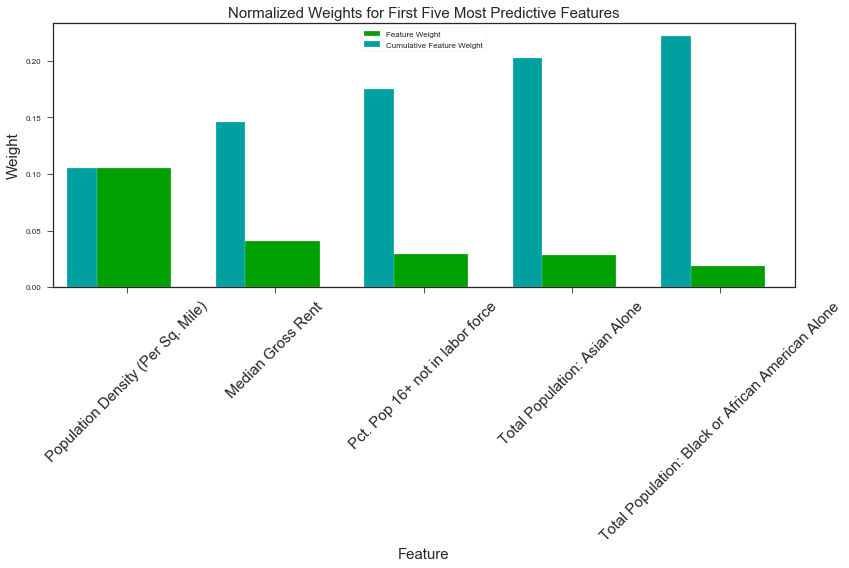

In [33]:
k_feature_plot(classifiers['rf'].feature_importances_, X_train, y_train)